In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyIsoPEP.IsotonicPEP import IsotonicPEP

In [ ]:
df_target = pd.read_csv("output/run1/splinePEP/0/peptide.target.txt", sep="\t")
df_decoy = pd.read_csv("output/run1/splinePEP/0/peptide.decoy.txt", sep="\t")
df_target["type"] = "0"
df_decoy["type"] = "1"
df_cat = pd.concat([df_target, df_decoy], ignore_index=True)
df_cat.to_csv("example/peptide.cat.txt", sep='\t', index=False)

In [2]:
pep_processor = IsotonicPEP()
df_cat = pd.read_csv("example/peptide.cat.txt", sep='\t', dtype={"type": str})
columns_to_drop = ["PSMId", "filename", "peptide", "proteinIds"]
df_cat = df_cat.drop(columns=columns_to_drop)
df_cat = df_cat.rename(columns={"posterior_error_prob": "spline"})
df_target = df_cat[df_cat["type"] == "0"]
df_target = df_target.copy()
df_target["obs2pep_cat"], df_target["obs2q_cat"] = pep_processor.pep_regression(obs=df_cat[["score", "type"]].values, method="obs2pep", target_label="0", decoy_label="1")

In [2]:
df_target = pd.read_csv("output/run1/splinePEP/0/peptide.target.txt", sep="\t")
df_decoy = pd.read_csv("output/run1/splinePEP/0/peptide.decoy.txt", sep="\t")
columns_to_drop = ["PSMId", "filename", "peptide", "proteinIds"]
df_target = df_target.drop(columns=columns_to_drop)
df_decoy = df_decoy.drop(columns=columns_to_drop)
df_target = df_target.rename(columns={"posterior_error_prob": "spline"})
df_decoy = df_decoy.rename(columns={"posterior_error_prob": "spline"})

In [3]:
pep_processor = IsotonicPEP()
df_target["obs2pep"], df_target["q_obs2pep"] = pep_processor.pep_regression(target=df_target["score"].values, decoy=df_decoy["score"].values, method="obs2pep")
df_target["q2pep"], df_target["q_q2pep"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="basic")
df_target["q2pep_ip"], df_target["q_q2pep_ip"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="ip")
df_target["q2pep_smooth"], df_target["q_q2pep_smooth"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="basic", smooth=True)
df_target["q2pep_ip_smooth"], df_target["q_q2pep_ip_smooth"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="ip", smooth=True)
df = df_target

In [ ]:
def estimate_q(df, pep_col):
    df = df.copy()
    df['orig_order'] = range(len(df))
    df_sorted = df.sort_values(by="q-value", kind="mergesort")
    df_sorted[f"q_{pep_col}"] = df_sorted[pep_col].cumsum() / np.arange(1, len(df_sorted) + 1)
    df_sorted = df_sorted.sort_values(by='orig_order').drop(columns='orig_order')
    return df_sorted

def cal_max_rel_diff(q_value, q_est):
    relative_difference = np.abs(q_est - q_value) / np.where(q_value != 0, q_value, np.nan)
    return np.nanmax(relative_difference) * 100

In [5]:
label_mapping = {
    'spline': {'label': 'Spline', 'linestyle': '-'},
    'obs2pep': {'label': 'TDC', 'linestyle': '-'},
    'q2pep': {'label': 'PAVA', 'linestyle': '-'},
    'q2pep_ip': {'label': 'ip-PAVA', 'linestyle': '-'},
    'q2pep_smooth': {'label': 'smooth PAVA', 'linestyle': '-'},
    'q2pep_ip_smooth': {'label': 'smooth ip-PAVA', 'linestyle': '-'}
}
methods = ["spline", "obs2pep", "q2pep", "q2pep_ip", "q2pep_smooth", "q2pep_ip_smooth"]

In [6]:
df = estimate_q(df, "spline")
q_values = df["q-value"].values
for m in methods:
    # df = estimate_q(df, m)
    max_diff = cal_max_rel_diff(df["q-value"].values, df[f"q_{m}"].values)
    print(f"{label_mapping[m]['label']}: {max_diff:.0f}%")

Spline: 207%
TDC: 77%
PAVA: 59%
ip-PAVA: 59%
smooth PAVA: 59%
smooth ip-PAVA: 59%


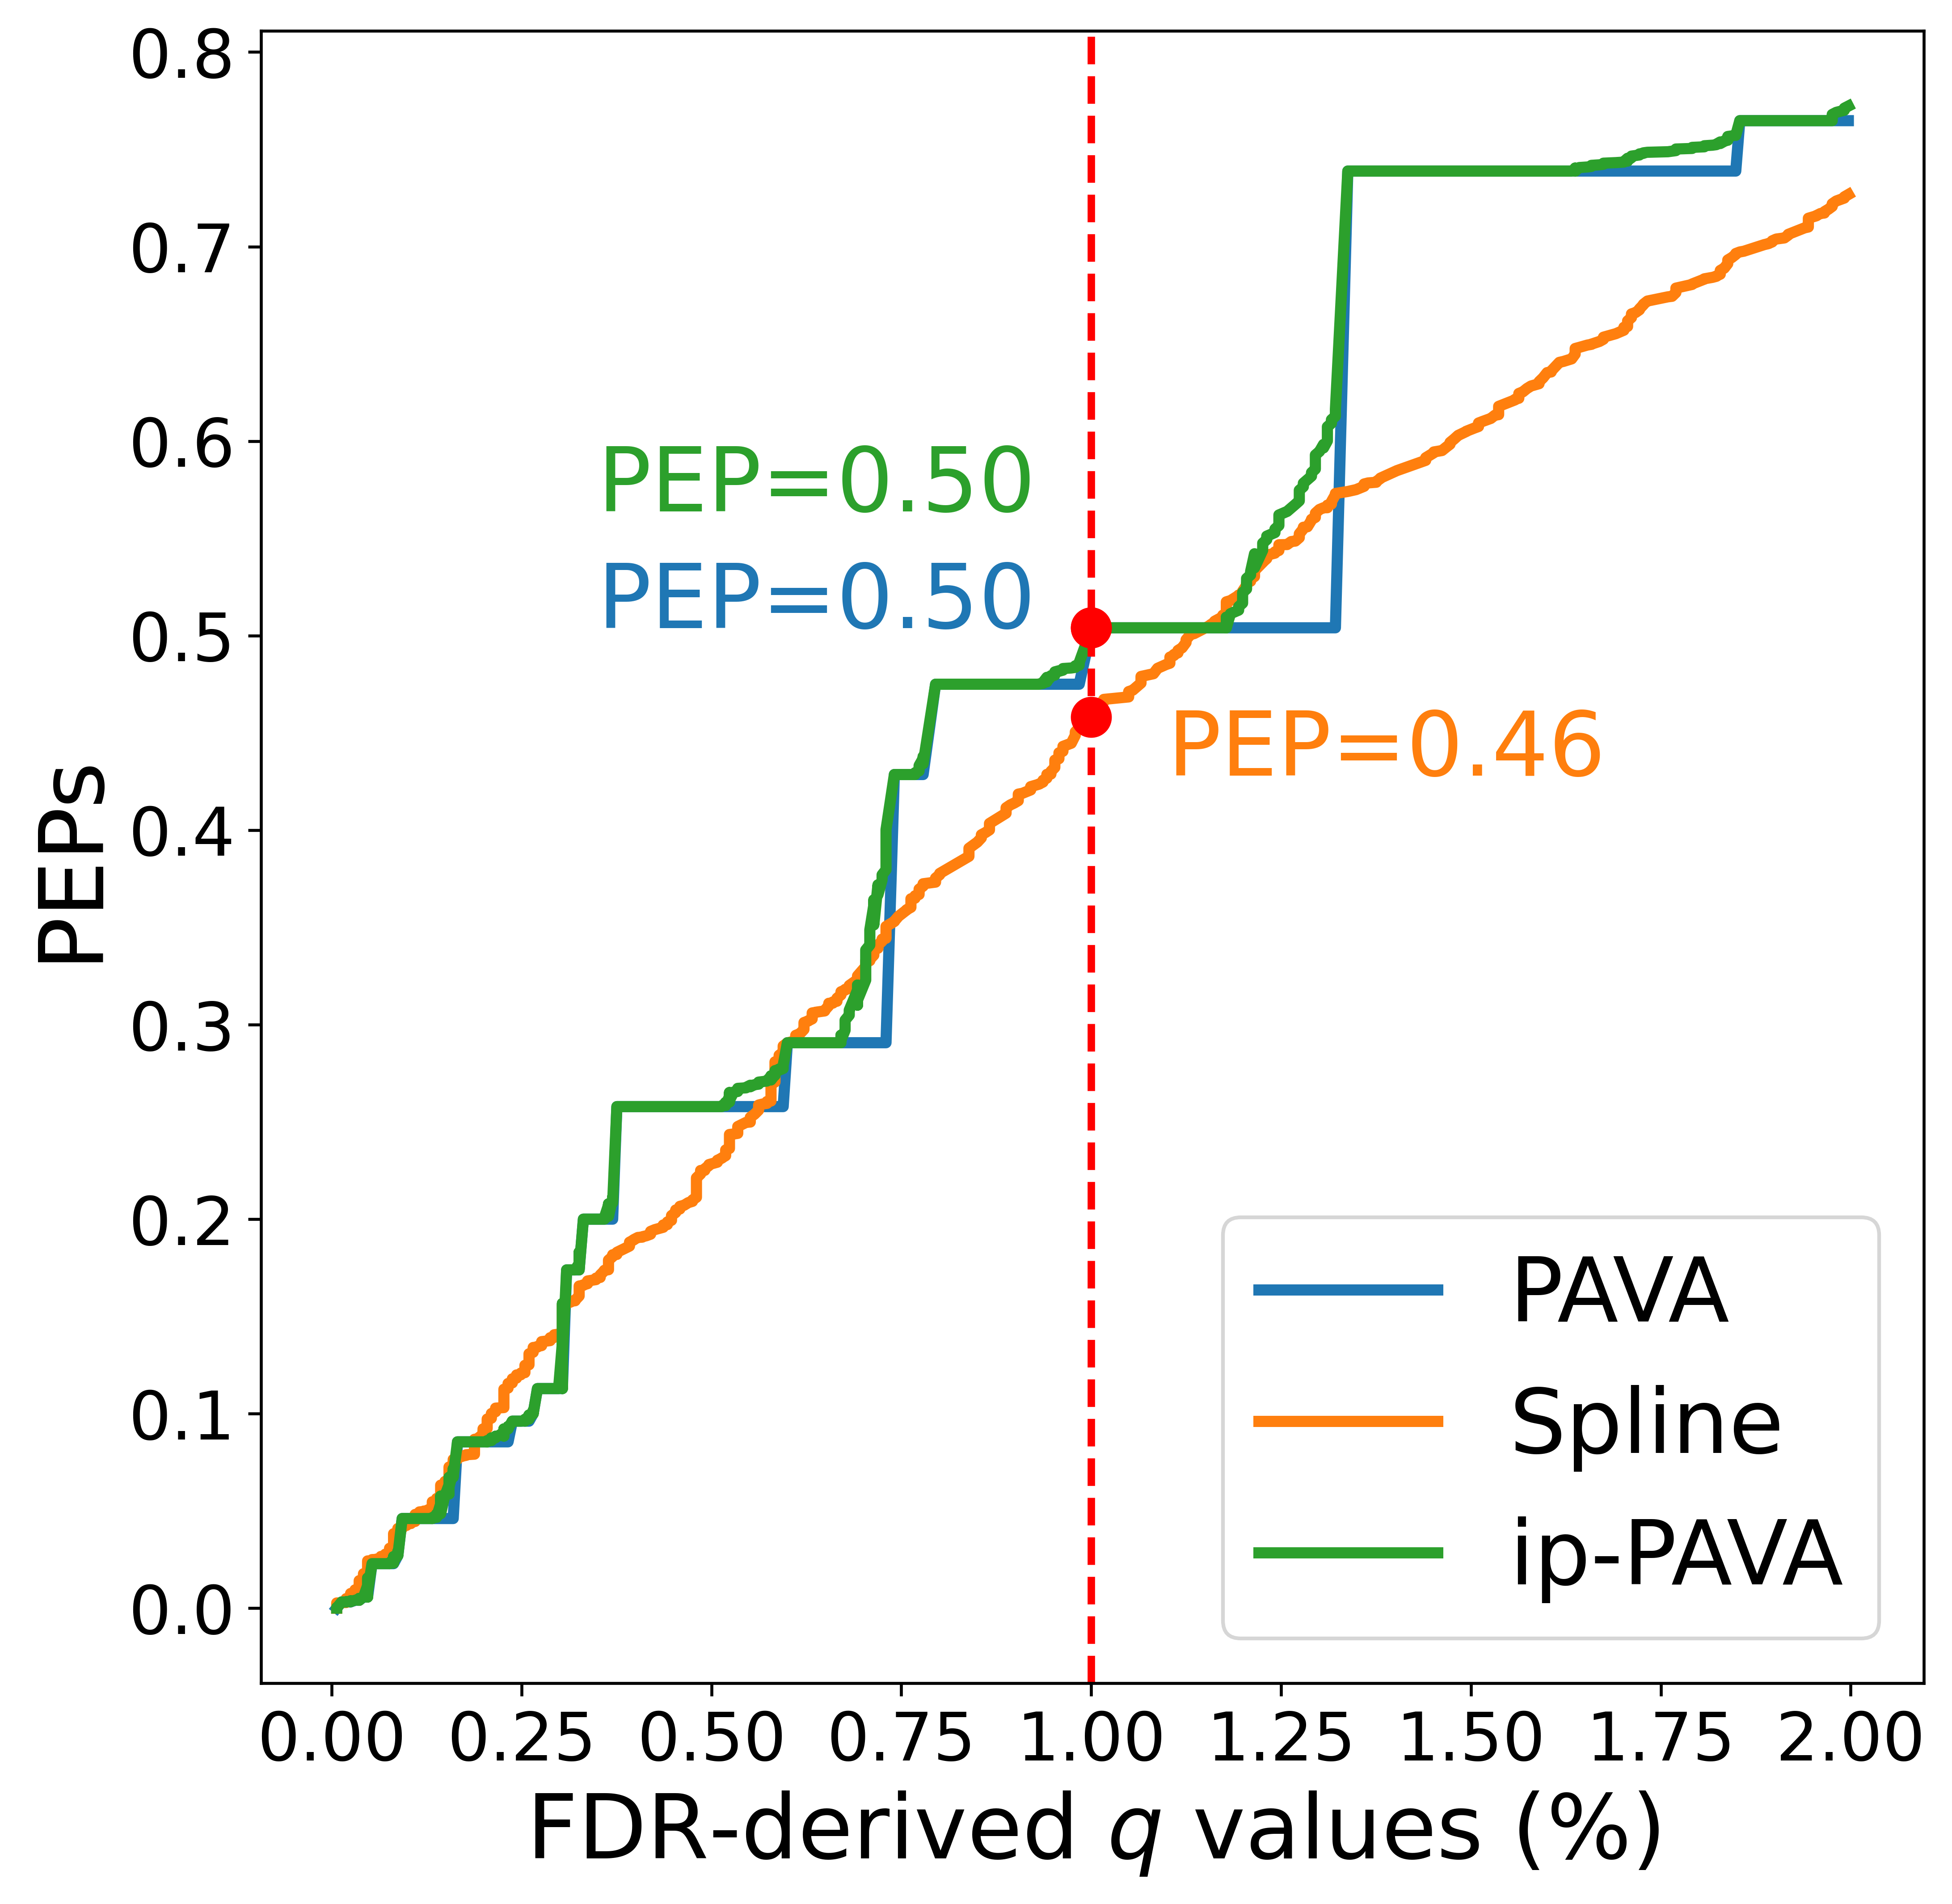

In [46]:
df_sub = df[df["q-value"] <= 0.02]
q_values = df_sub["q-value"] * 100
vertical_x = 1
pep_pava = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "q2pep"]
pep_spline = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "spline"]
pep_ip_pava = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "q2pep_ip"]

plt.figure(figsize=(8, 8), dpi=600)
plt.plot(q_values, df_sub["q2pep"], label='PAVA', linewidth=3, color='tab:blue')
plt.plot(q_values, df_sub["spline"], label='Spline', linewidth=3, color='tab:orange')
plt.plot(q_values, df_sub["q2pep_ip"], label='ip-PAVA', linewidth=3, color='tab:green')

plt.axvline(x=vertical_x, color='red', linestyle='--', linewidth=2)
plt.scatter([vertical_x], [pep_pava], color='red', s=100, zorder=3)
plt.scatter([vertical_x], [pep_spline], color='red', s=100, zorder=3)
plt.scatter([vertical_x], [pep_ip_pava], color='red', s=100, zorder=3)

plt.text(vertical_x-0.65, pep_pava, f"PEP={pep_pava:.2f}", fontsize=24, color='tab:blue')
plt.text(vertical_x+0.1, pep_spline-0.03, f"PEP={pep_spline:.2f}", fontsize=24, color='tab:orange')
plt.text(vertical_x-0.65, pep_ip_pava+0.06, f"PEP={pep_ip_pava:.2f}", fontsize=24, color='tab:green')

plt.xlabel("FDR-derived $q$ values (%)", fontsize=24)
plt.ylabel("PEPs", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.show()

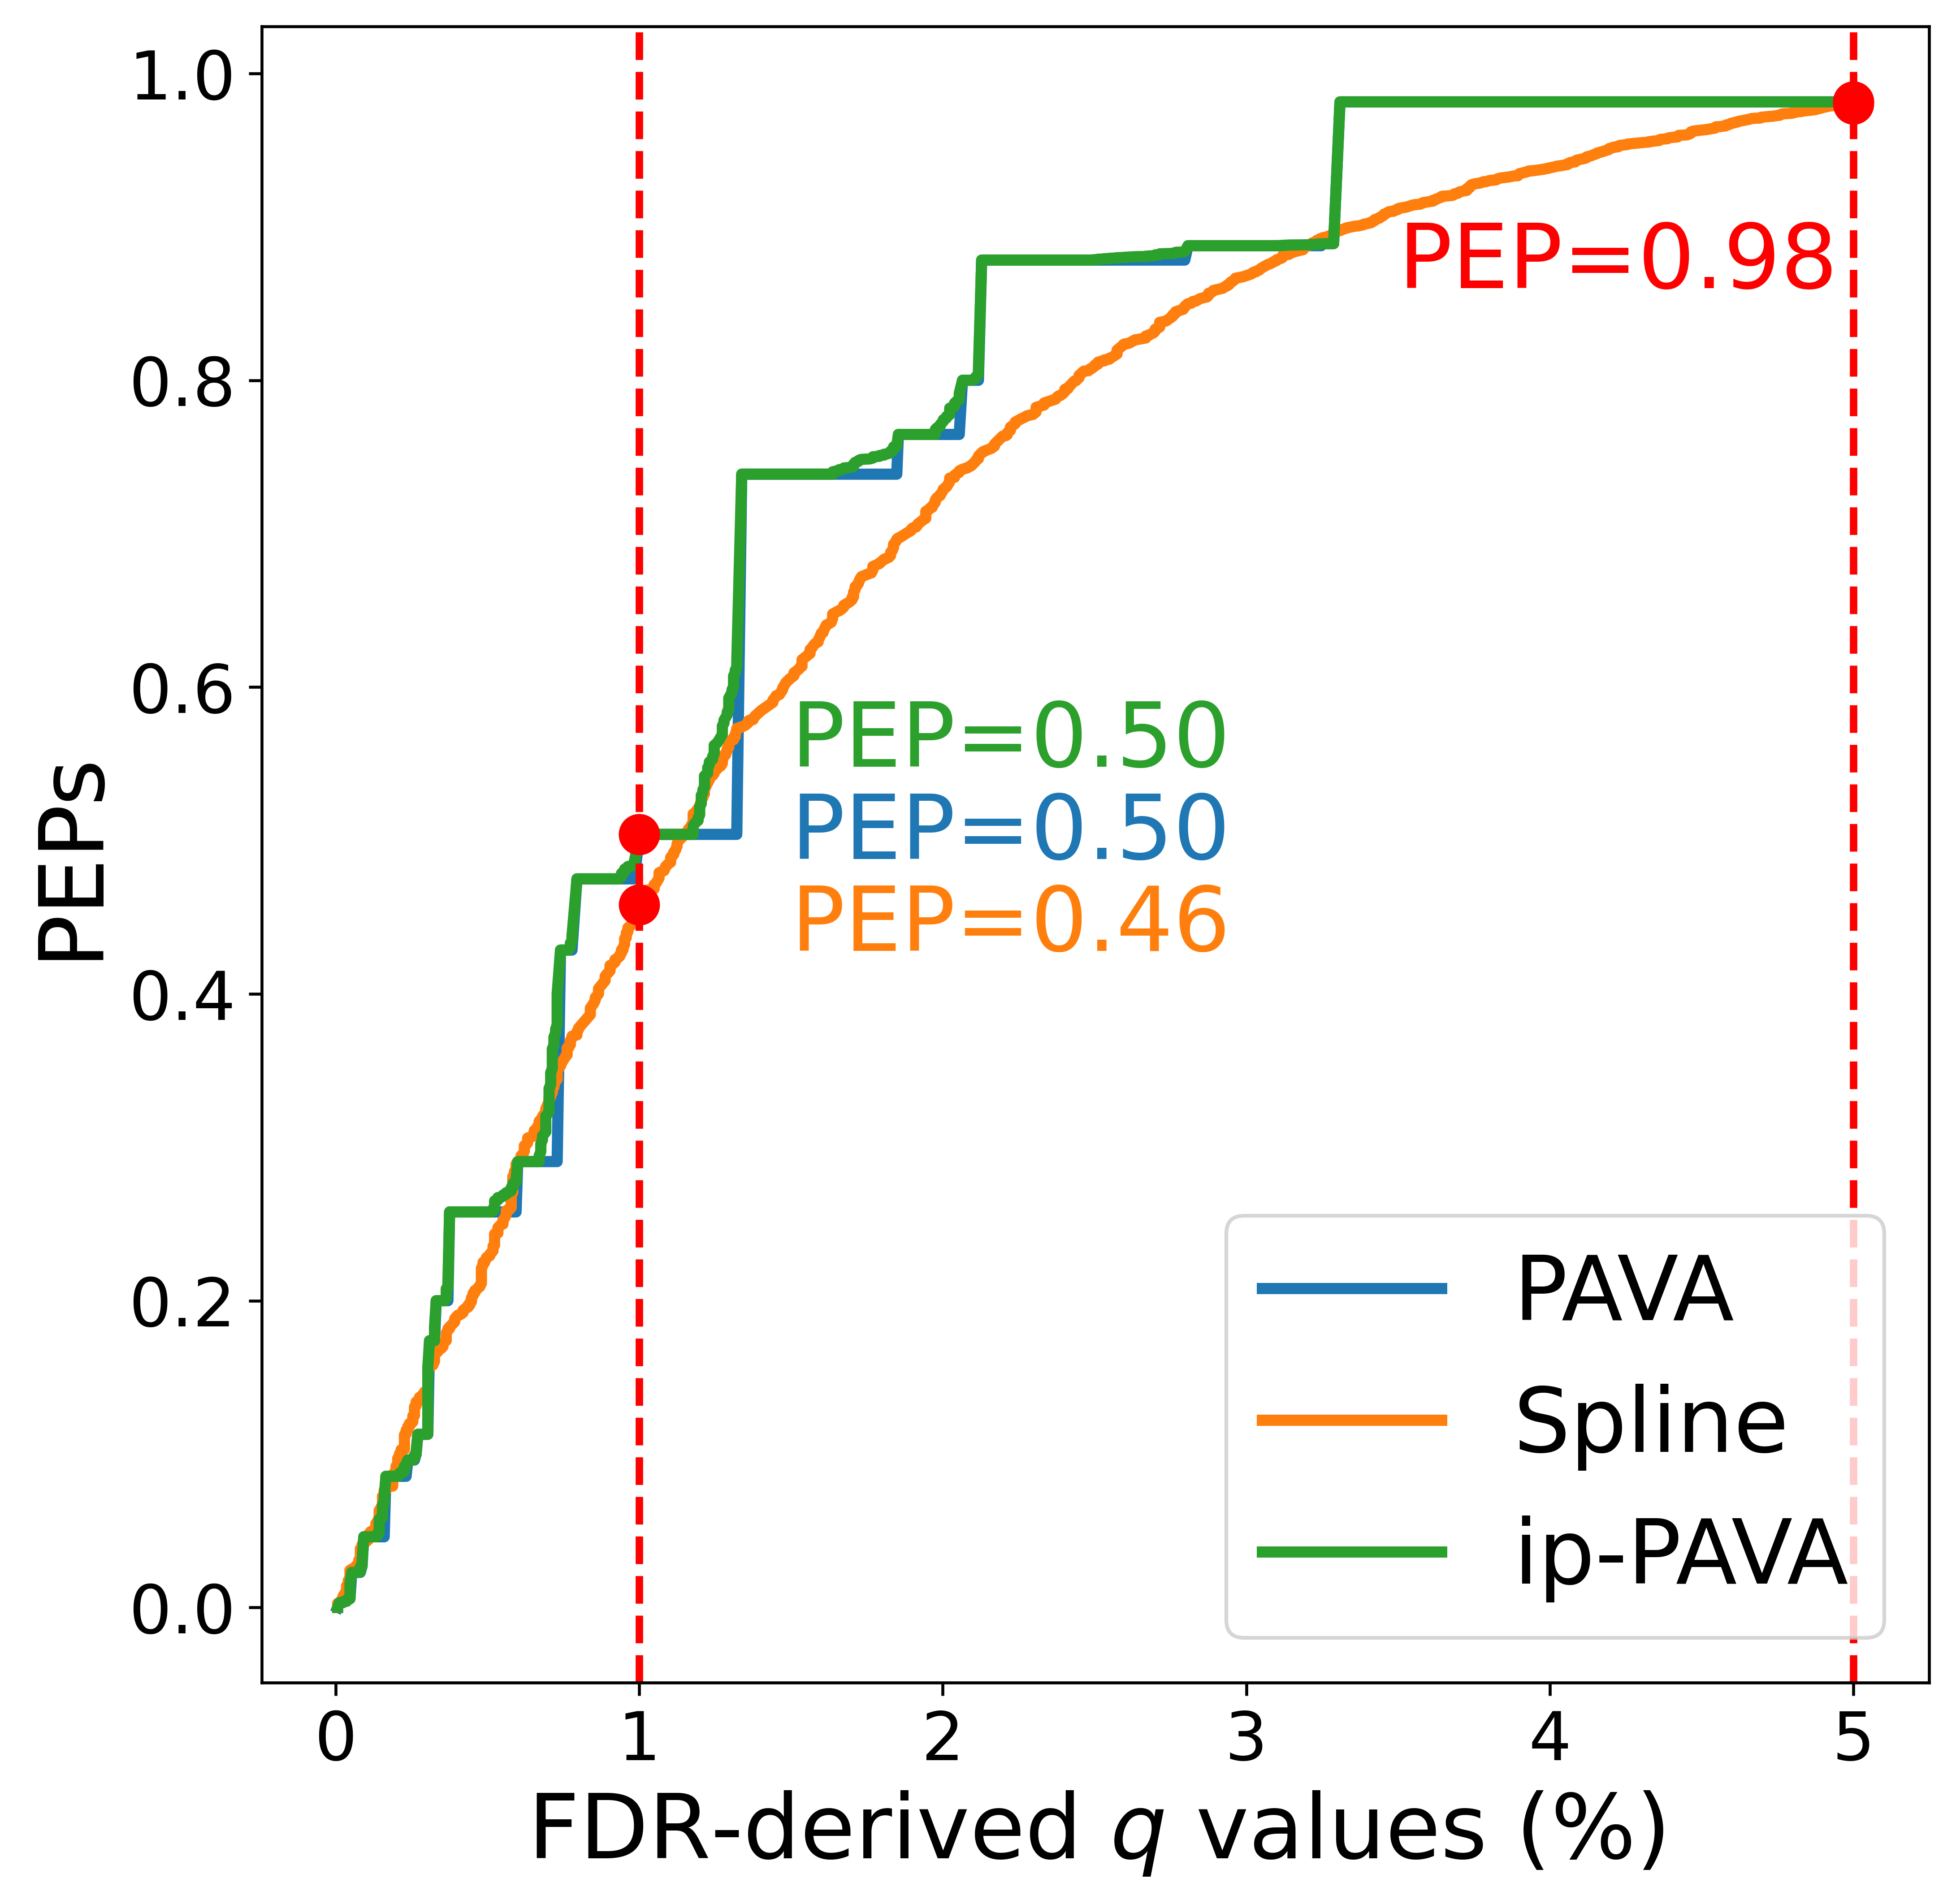

In [24]:
df_sub = df[df["q-value"] <= 0.05]
q_values = df_sub["q-value"] * 100
vertical_x = 1
pep_pava = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "q2pep"]
pep_spline = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "spline"]
pep_ip_pava = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "q2pep_ip"]

vertical_x5 = 5
pep_pava5 = df_sub.loc[(q_values - vertical_x5).abs().idxmin(), "q2pep"]
pep_spline5 = df_sub.loc[(q_values - vertical_x5).abs().idxmin(), "spline"]
pep_ip_pava5 = df_sub.loc[(q_values - vertical_x5).abs().idxmin(), "q2pep_ip"]

plt.figure(figsize=(8, 8), dpi=600)
plt.plot(q_values, df_sub["q2pep"], label='PAVA', linewidth=3, color='tab:blue')
plt.plot(q_values, df_sub["spline"], label='Spline', linewidth=3, color='tab:orange')
plt.plot(q_values, df_sub["q2pep_ip"], label='ip-PAVA', linewidth=3, color='tab:green')

plt.axvline(x=vertical_x, color='red', linestyle='--', linewidth=2)
plt.scatter([vertical_x], [pep_pava], color='red', s=100, zorder=3)
plt.scatter([vertical_x], [pep_spline], color='red', s=100, zorder=3)
plt.scatter([vertical_x], [pep_ip_pava], color='red', s=100, zorder=3)

plt.text(vertical_x+0.5, pep_spline+0.03, f"PEP={pep_pava:.2f}", fontsize=24, color='tab:blue')
plt.text(vertical_x+0.5, pep_spline-0.03, f"PEP={pep_spline:.2f}", fontsize=24, color='tab:orange')
plt.text(vertical_x+0.5, pep_spline+0.09, f"PEP={pep_ip_pava:.2f}", fontsize=24, color='tab:green')

plt.axvline(x=vertical_x5, color='red', linestyle='--', linewidth=2)
plt.scatter([vertical_x5], [pep_pava5], color='red', s=100, zorder=3)
plt.scatter([vertical_x5], [pep_spline5], color='red', s=100, zorder=3)
plt.scatter([vertical_x5], [pep_ip_pava5], color='red', s=100, zorder=3)
plt.text(vertical_x5-1.5, pep_spline5-0.12, f"PEP={pep_ip_pava5:.2f}", fontsize=24, color='red')

plt.xlabel("FDR-derived $q$ values (%)", fontsize=24)
plt.ylabel("PEPs", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.show()

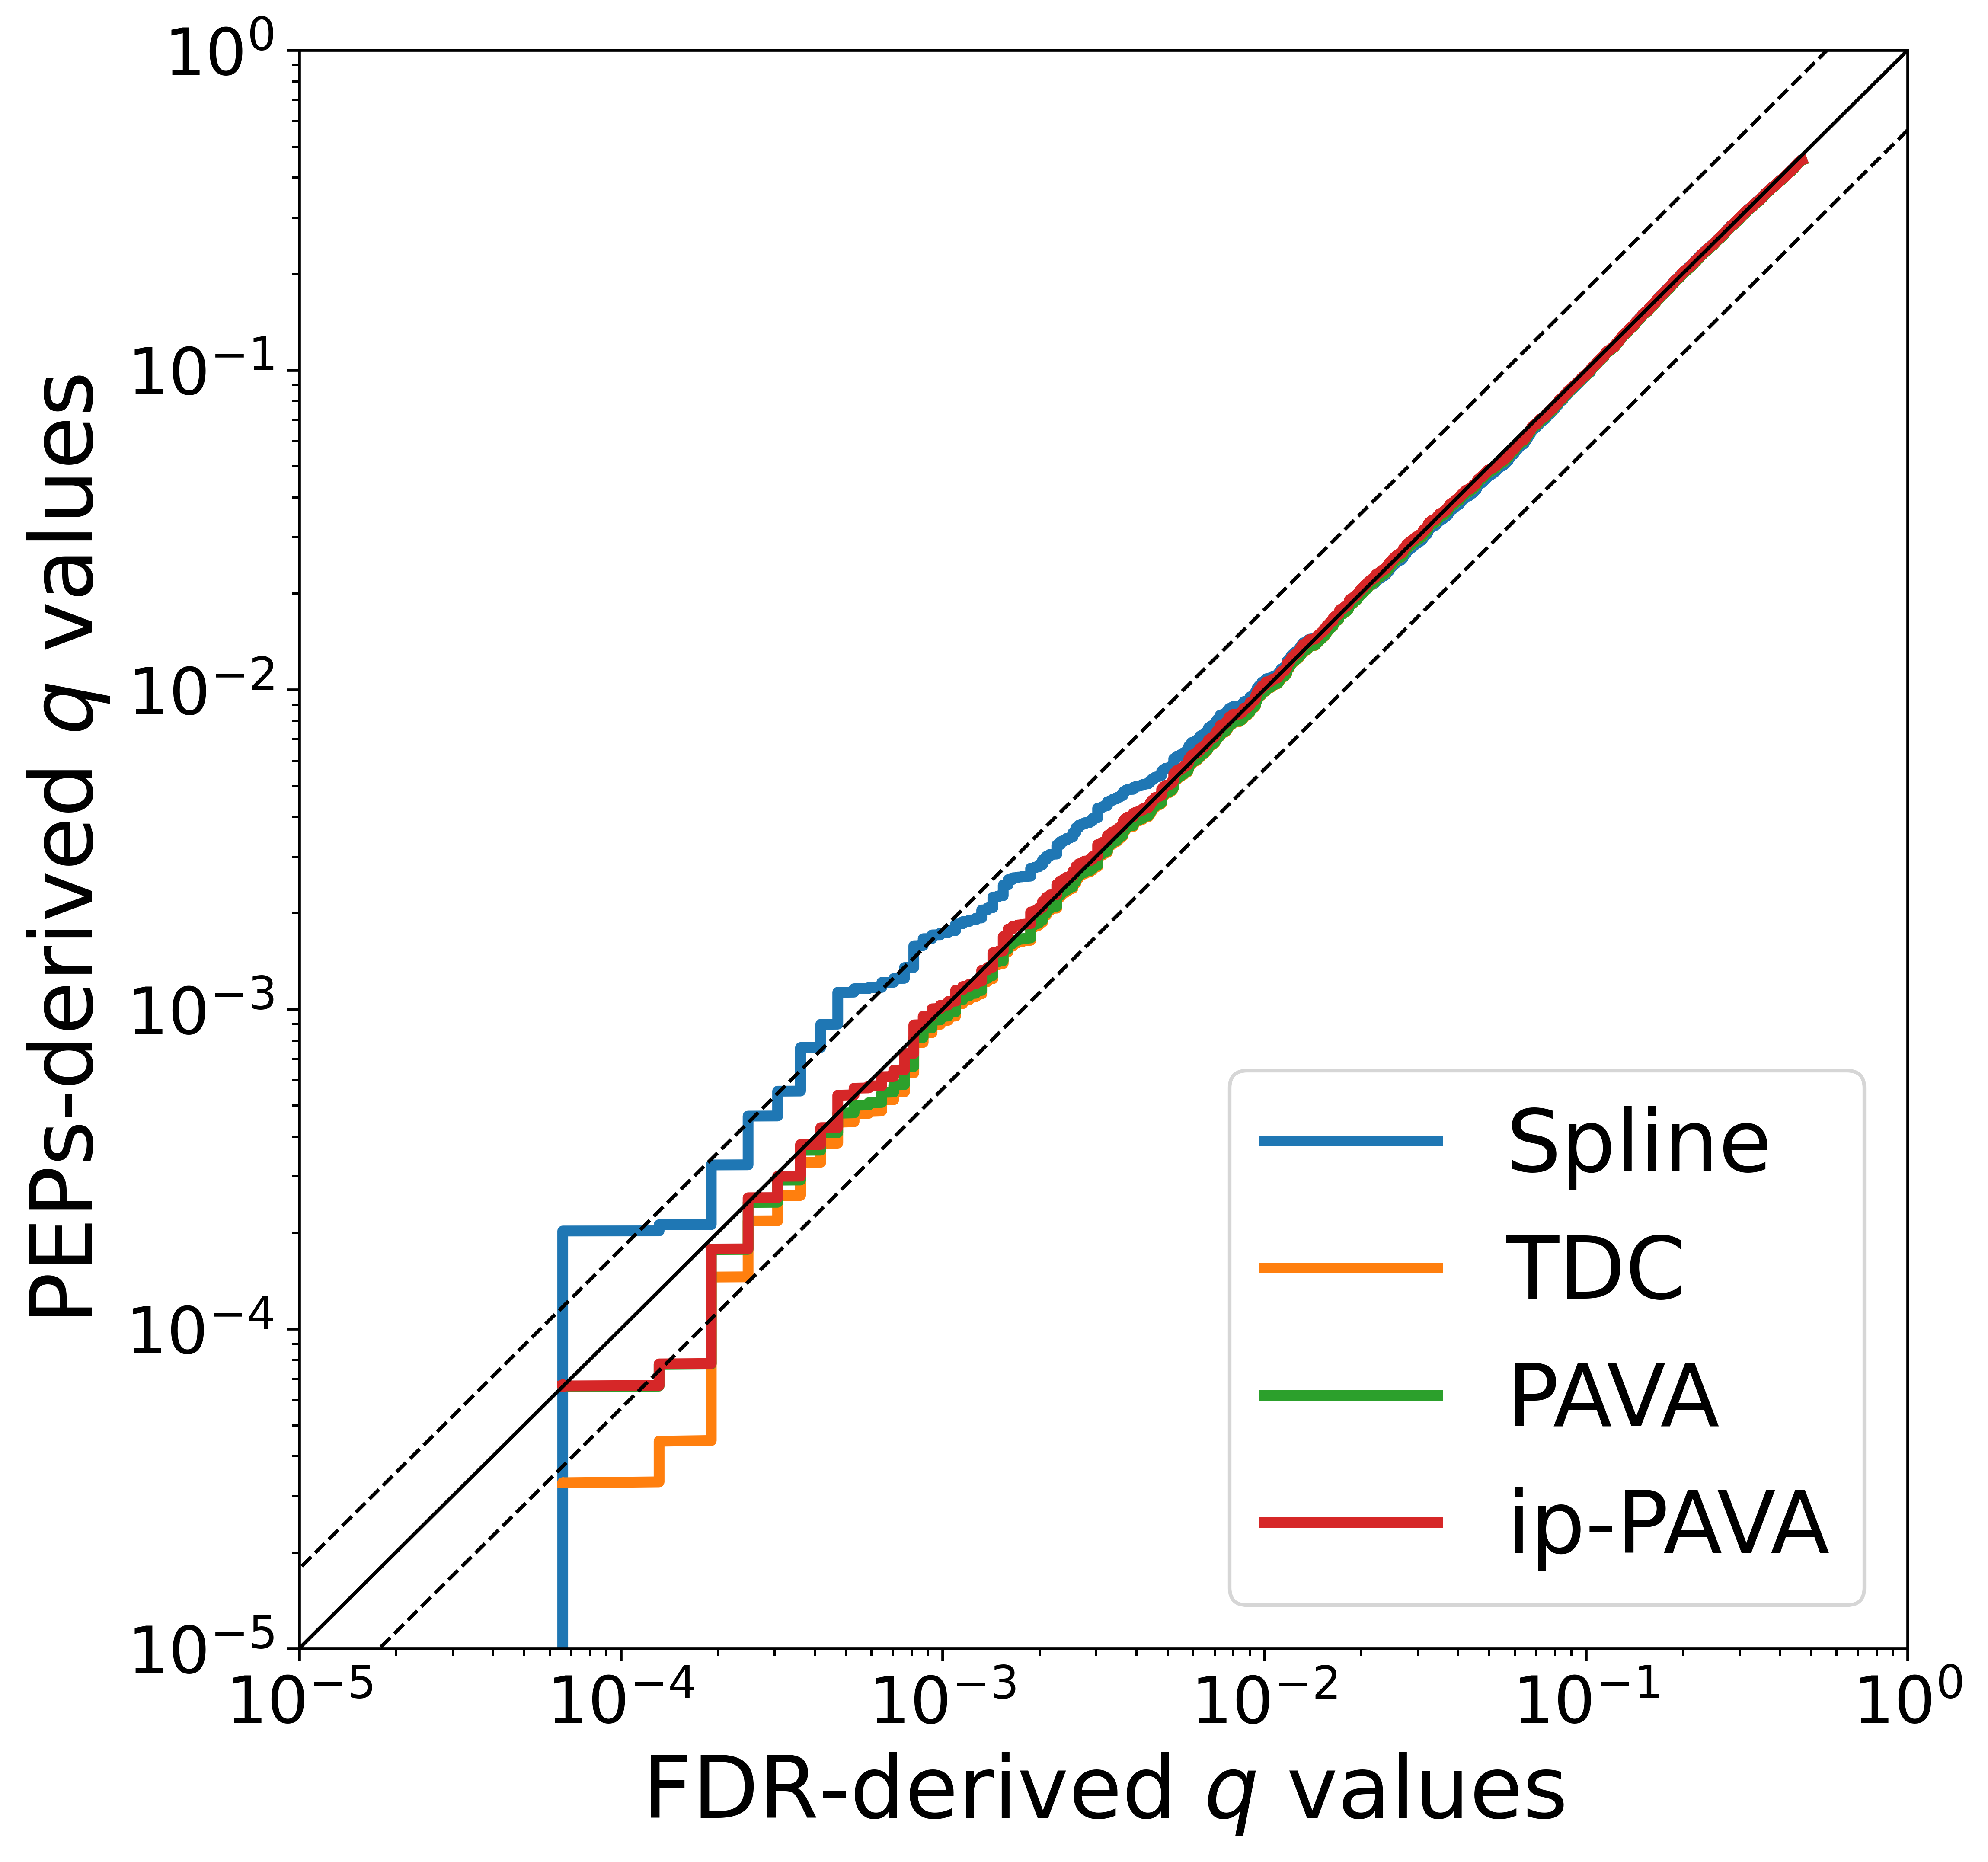

In [7]:
methods = ["spline", "obs2pep", "q2pep", "q2pep_ip"]
plt.figure(figsize=(8, 8), dpi=600)
# plt.text(0.05, 0.9, "comment1", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
# plt.text(0.05, 0.85, "comment2", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
# plt.text(0.05, 0.8, "comment3", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
for m in methods:
    plt.plot(df["q-value"], df[f"q_{m}"], label=label_mapping[m]['label'], linestyle=label_mapping[m]['linestyle'], linewidth=3)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=1, linestyle="--")
plt.plot(a, c, c="k", linewidth=1, linestyle="--")
plt.plot(a, a, c="k", linewidth=1)
plt.xlabel("FDR-derived $q$ values", fontsize=24)
plt.ylabel("PEPs-derived $q$ values", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.00001, 1)
plt.ylim(0.00001, 1)
# plt.savefig(f"figs/q-q.png",bbox_inches="tight")
plt.show()

<Figure size 4800x4800 with 0 Axes>

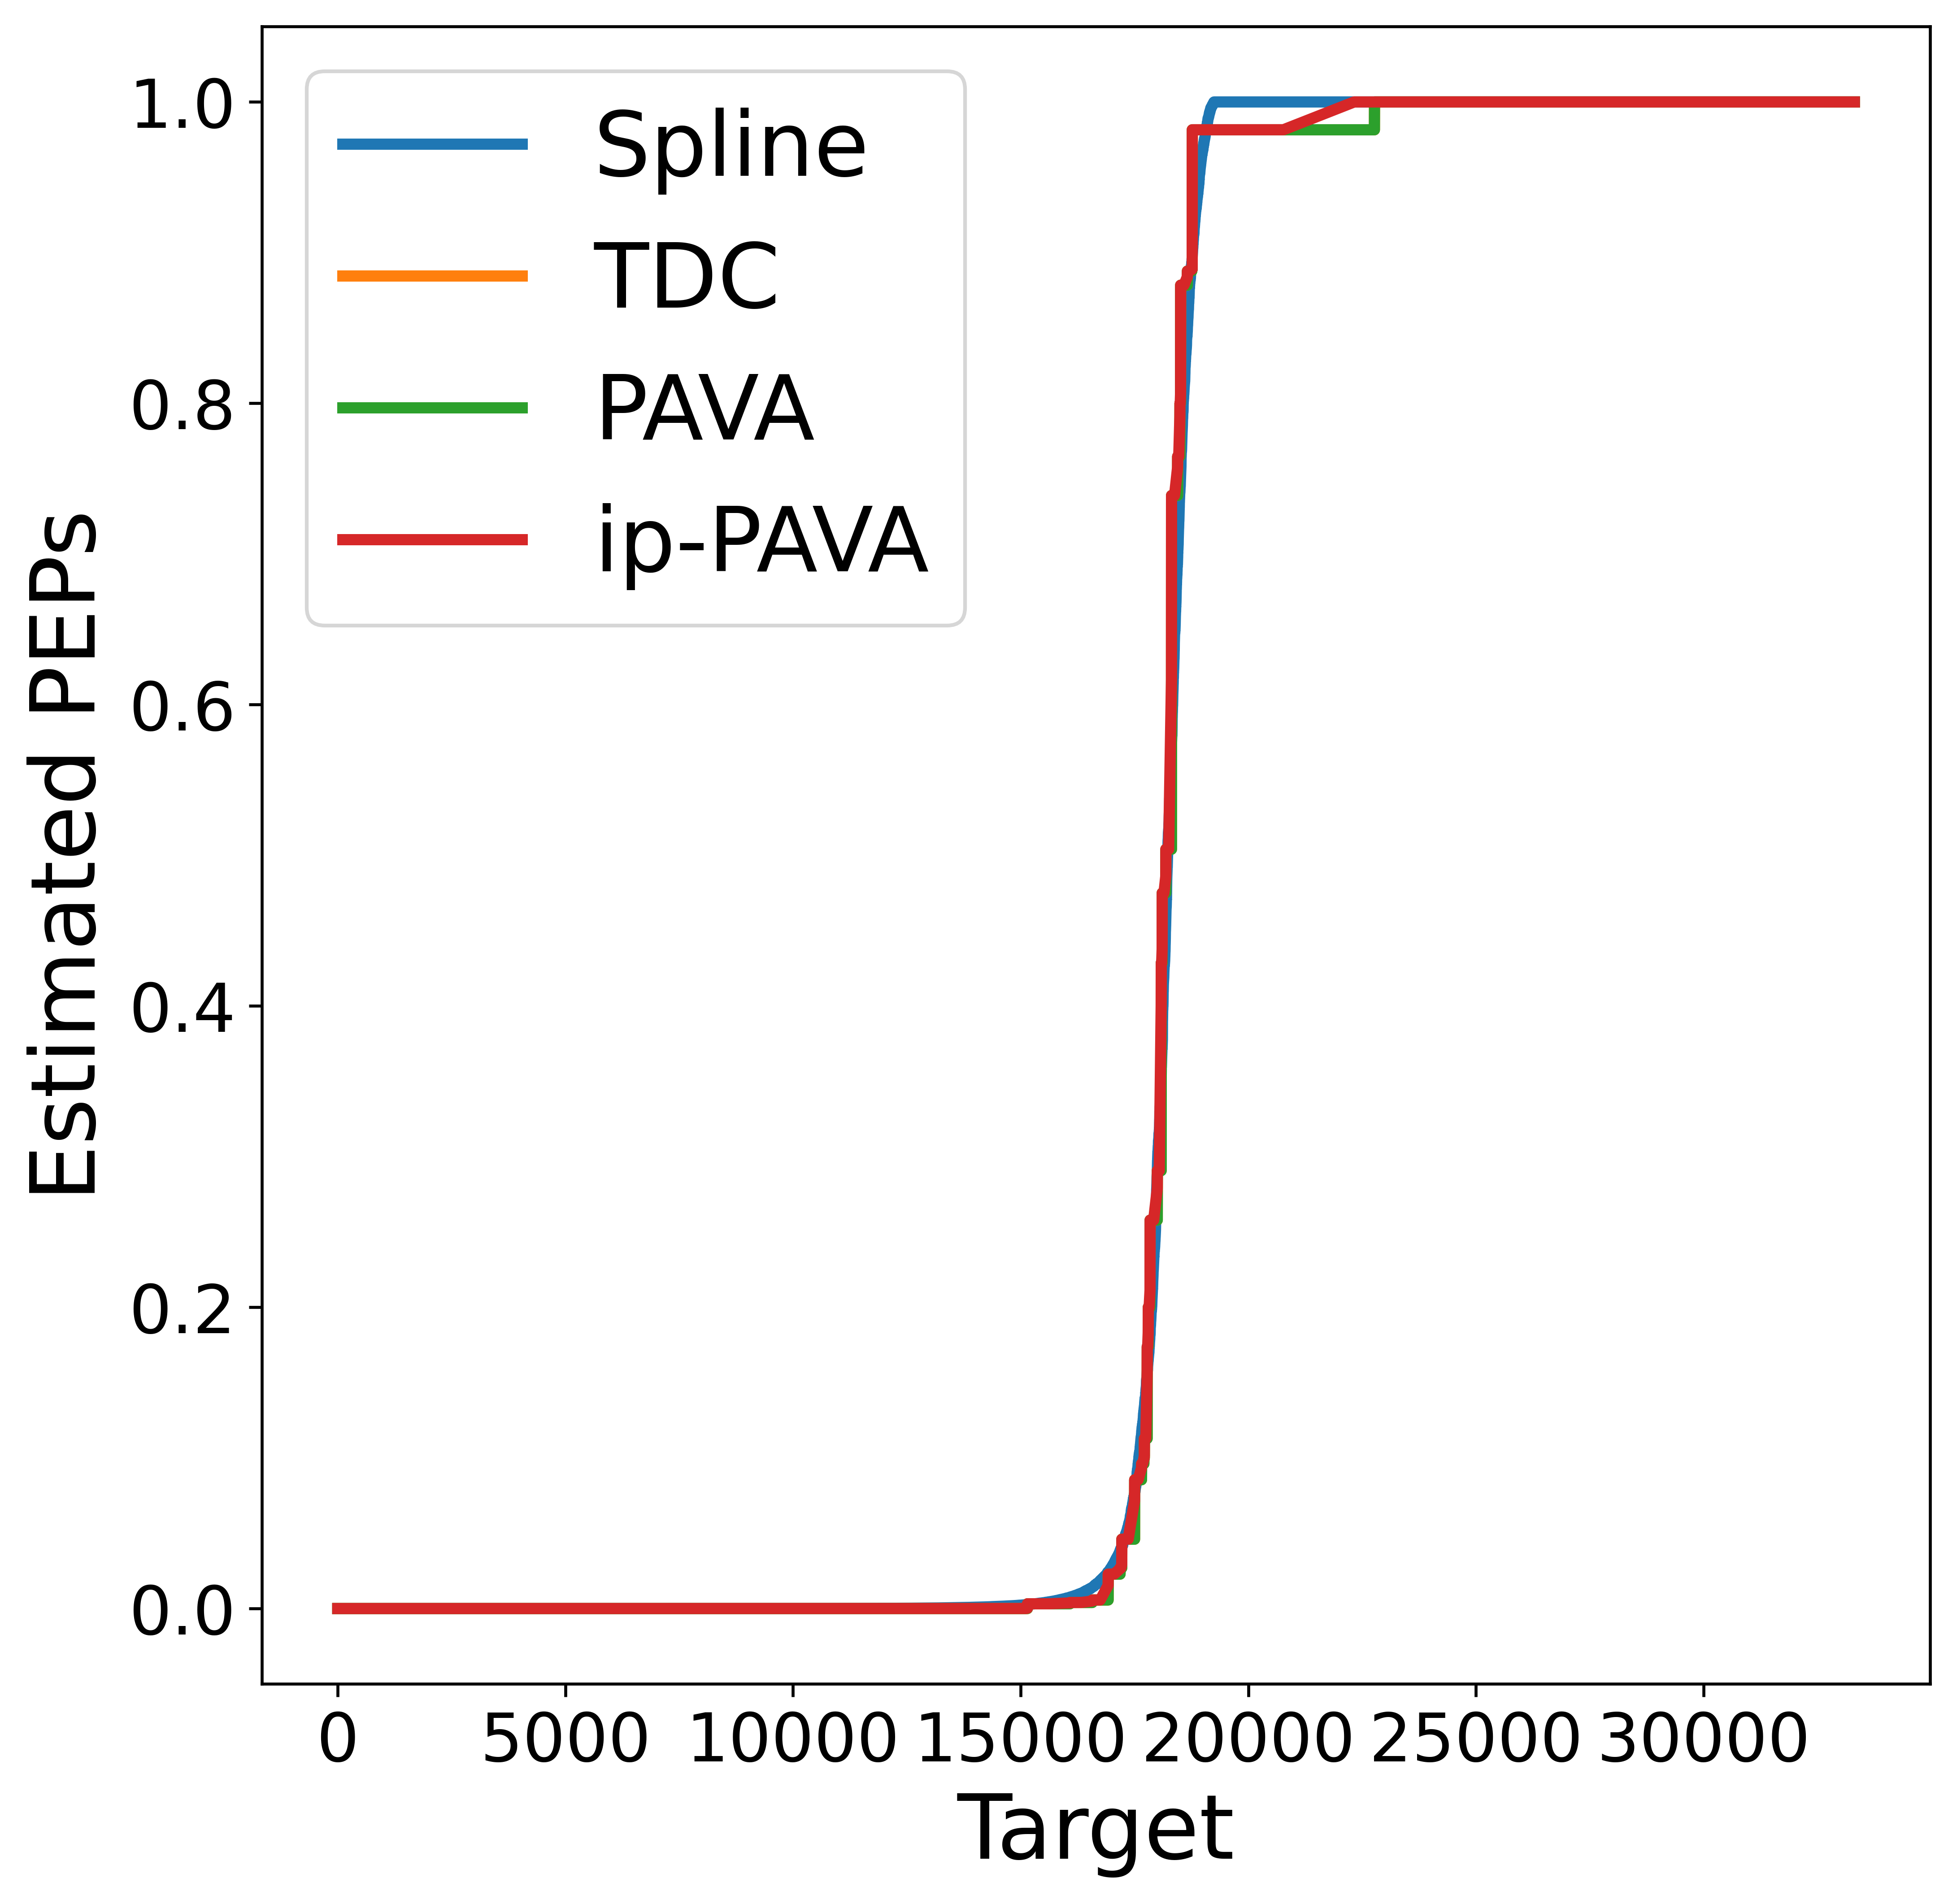

In [18]:
methods = ["spline", "obs2pep", "q2pep", "q2pep_ip"]
plt.figure(figsize=(8, 8), dpi=600)
plt.figure(figsize=(8, 8), dpi=600)
q_values = df["q-value"].values
x_axis = np.arange(1, len(q_values) + 1)

for m in methods:
    plt.plot(x_axis, df[m], label=label_mapping[m]['label'], linewidth=3, linestyle=label_mapping[m]['linestyle'])

plt.xlabel("Target", fontsize=24)
plt.ylabel("Estimated PEPs", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="upper left", fontsize=24)
plt.show()